In [75]:
import numpy as np
import time
import os

delta_t = 0.01
G = 25

class Body():
    def __init__(self, mass, radius, position, velocity, star=False):
        self.mass = mass
        self.radius = radius
        self.position = position
        self.velocity = velocity
        self.star = star

        self.draw_sphere()
        self.normals = self.points.copy() / radius
        self.points = self.points + position

    def draw_sphere(self):
        thetas = np.arange(0, 2 * np.pi, 0.05)

        circle = np.array([
            self.radius * np.cos(thetas),
            np.zeros(thetas.shape),
            self.radius * np.sin(thetas)
        ])

        m = self.rotation_matrix(thetas)

        self.points = (m @ circle).transpose(0,2,1).reshape(-1,3)

    def move(self, bodies):
        for body in bodies:
            # calculate gravitational force
            F = -G * self.mass * body.mass * (self.position - body.position) \
                / np.linalg.norm(self.position - body.position) ** 3

            # update velocity
            delta_v = F * delta_t
            self.velocity = self.velocity + delta_v

        # update position
        delta_position = self.velocity * delta_t
        self.position = self.position + delta_position
        self.points = self.points + delta_position


    def rotation_matrix(self, theta):
        c = np.cos(theta)
        s = np.sin(theta)
        m = np.zeros((len(theta),3,3))
        m[:,2,2] = 1
        m[:,:2,:2] = np.array([
            [c,-s],
            [s,c],
        ]).transpose(2,0,1)
        return m

    def shade(self, star_position=None):
        if self.star:
            self.shading = np.ones(self.points.shape[0])
        else:
            light_direction = self.position - star_position
            self.shading = -(self.normals @ light_direction)

class Camera():
    def __init__(self, position, focus, screen_distance):
        self.position = position
        self.focus = focus
        self.screen_distance = screen_distance

        direction = focus - position
        self.direction = direction / np.linalg.norm(direction)

        left_right = np.cross(self.direction, np.array([0,0,1]))
        self.left_right = left_right / np.linalg.norm(left_right)

        top_bottom = np.cross(left_right, self.direction)
        self.top_bottom = top_bottom / np.linalg.norm(top_bottom)

        self.greyscale = ' .:-=+*#%@'

    def project(self, bodies):
        points = np.concatenate([body.points for body in bodies])
        shading = np.concatenate([body.shading for body in bodies])

        # project the torus on the screen
        proj_tb = self.screen_distance * ((points - self.position) @ self.top_bottom) \
            / ((points - self.position) @ self.direction)
        proj_lr = self.screen_distance * ((points - self.position) @ self.left_right) \
            / ((points - self.position) @ self.direction)

        # sort the points on distance to camera so only the closest points are shown
        distance_to_camera = points @ self.direction
        order = (-distance_to_camera).argsort()

        # set up the screen
        screen = np.empty((150,60), dtype='str')
        screen[:] = ' '

        # convert x, y and shading to digital values
        digital_lr = np.digitize(proj_lr, np.linspace(-1,1,screen.shape[0]))
        digital_tb = np.digitize(proj_tb, np.linspace(-1,1,screen.shape[1]))
        digital_shading = np.digitize(shading, np.linspace(shading.min(),shading.max(), 10)) - 1

        # fill the screen
        for x, y, shade in zip(digital_lr[order], digital_tb[order], digital_shading[order]):
            screen[x,y] = self.greyscale[shade]

        return np.flip(screen.T, axis=0)

c = Camera(position=np.array([-10, 0, 10]), focus=np.array([0,0,0]), screen_distance=1)
sun = Body(1,1,np.array([0,0,0]), np.array([0,0,0]), star=True)
earth = Body(1,0.5, np.array([-7,0,0]), np.array([0,1,0]))




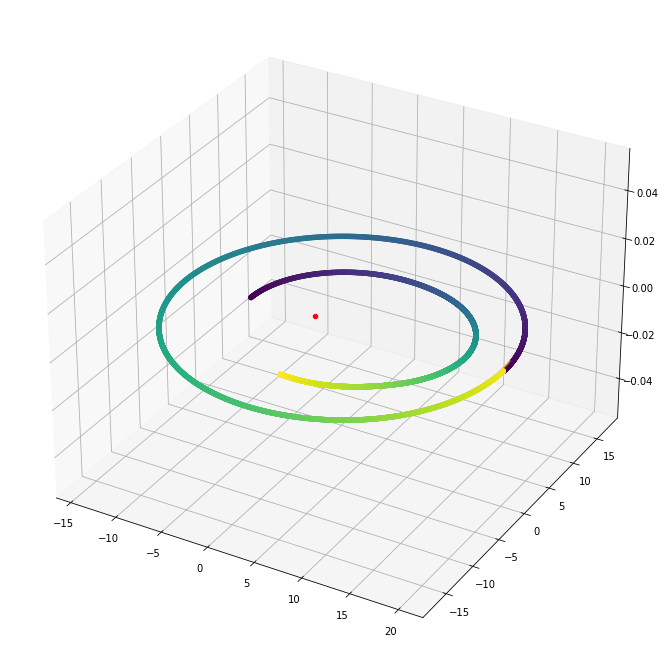

In [139]:
from turtle import pos
import matplotlib.pyplot as plt

delta_t = 0.001
G = 25

c = Camera(position=np.array([-10, 0, 6]), focus=np.array([0,0,0]), screen_distance=1)
sun = Body(100,1,np.array([0,0,0]), np.array([0,0,0]), star=True)
earth = Body(1,0.5, np.array([-7,0,0]), np.array([0,22,0]))
jupyter = Body(5,0.75, np.array([20,0,0]), np.array([0,23,0]))

earth_positions = []
jupyter_positions = []
for ix in range(4000):
    earth.move([sun, jupyter])
    jupyter.move([sun, earth])
    earth_positions.append(earth.position.copy())
    jupyter_positions.append(jupyter.position.copy())


earth_positions = np.array(earth_positions)
jupyter_positions = np.array(jupyter_positions)
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')

ax.scatter(earth_positions[:,0], earth_positions[:,1], earth_positions[:,2], c=np.linspace(0,1,len(earth_positions)).tolist())
ax.scatter(jupyter_positions[:,0], jupyter_positions[:,1], jupyter_positions[:,2], c=np.linspace(0,1,len(jupyter_positions)).tolist())
ax.scatter(0,0,0, c='r')

plt.show()

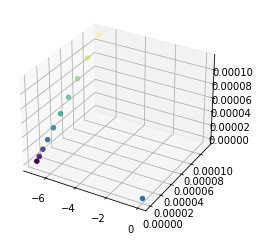

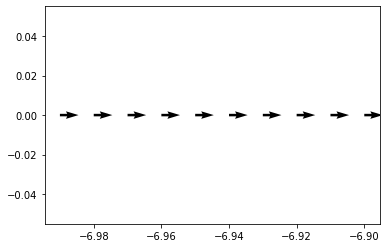

In [42]:
plt.quiver(positions[:,0], positions[:,1], velocities[:,0], velocities[:,1])

In [42]:
sun.points.shape

(15876, 3)

In [41]:
np.concatenate((sun.points, earth.points)).shape

(31752, 3)

In [34]:
shade = np.empty(earth.normals.shape[0])
for i in range(earth.normals.shape[0]):
    ray = (earth.points[i] - sun.position)
    ray = ray / np.linalg.norm(ray)
    shade[i] = ray @ earth.normals[i]

In [33]:
shade

array([4.        , 3.99625078, 3.9850125 , ..., 3.9717947 , 3.98798026,
       3.99669742])